## Step 1: Download the data

You can download the data for this notebook here: https://www.kaggle.com/c/titanic/data

## Step 2: Work through the notebook
    
First we will import all the relevant dependencies we need.

If you don't have any of these, the notebook will throw an error. The error will likely tell you what you don't have. Then you'll have to install it.

You can usually figure out how to install it by Googling: "how to install [the thing you don't have]".

**PS** If you have any questions, feedback, advice or bug fixes, please let me know.

In [ ]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
#import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

### Loading in the data

After we've downloaded the data, we need to get it into the notebook.

I've stored my downloaded data in a file called `data`.

In [6]:
# Import train & test data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv') # example of what a submission should look like

In [7]:
# View the training data
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [9]:
# View the test data (same columns as the training data)
test.head() # head = view first 5 lines

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [5]:
# View the example submisison dataframe
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [11]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

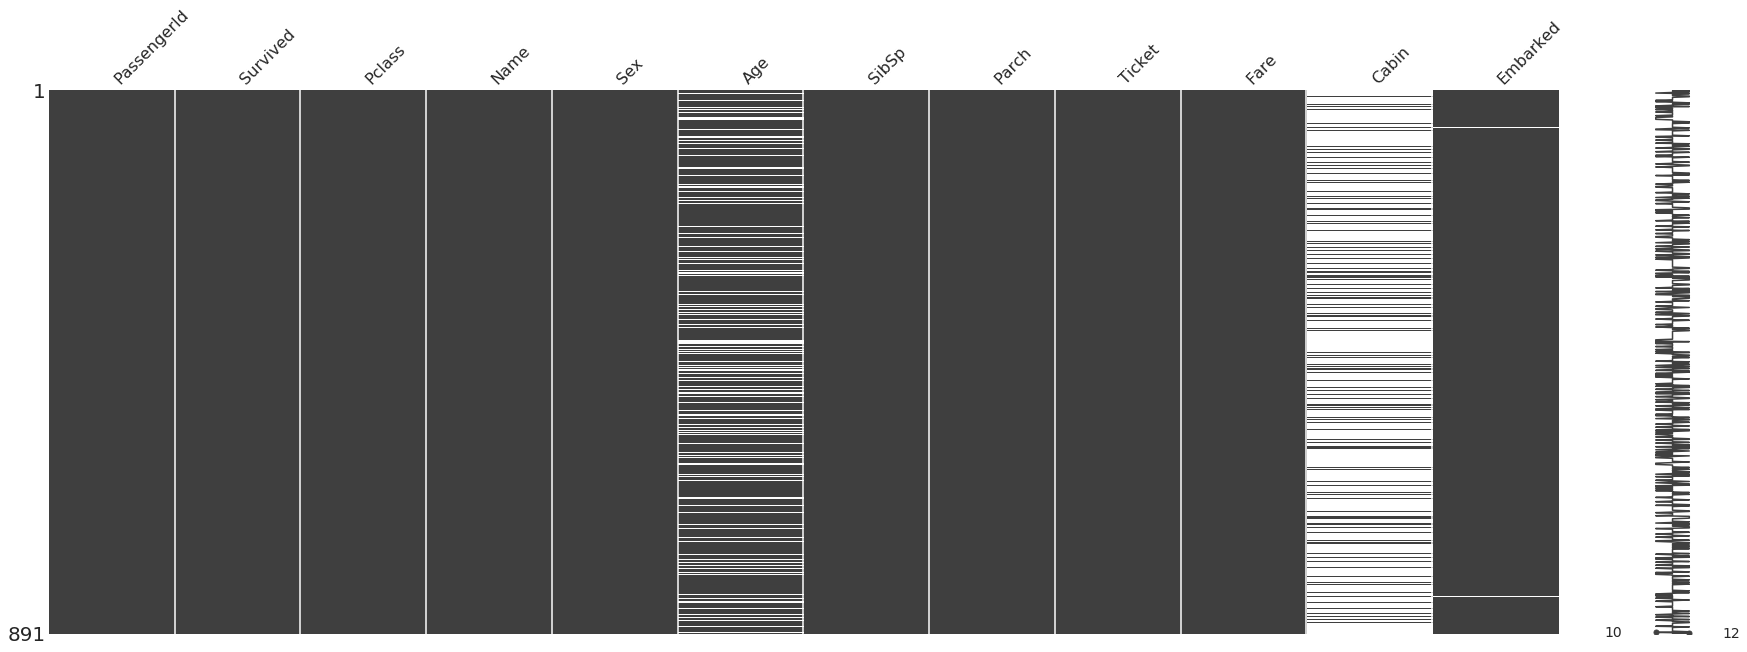

In [13]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

Ok we can clearly see some missing values here. Especially in the cabin column.

It's important to visualise missing values early so you know where the major holes are in your dataset.

Knowing this informaiton will help with your EDA and figuring out what kind of data cleaning and preprocessing is needed.

In [17]:
# Let's write a little function to show us how many missing values
# there are
def find_missing_values(df, columns):
    """
    Finds number of rows where certain columns are missing values.
    ::param_df:: = target dataframe
    ::param_columns:: = list of columns
    """
    missing_vals = {}
    print("Number of missing or NaN values for each column:")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_vals[column] = df_length-total_column_values
        #missing_vals.append(str(column)+ " column has {} missing or NaN values.".format())
    return missing_vals

missing_values = find_missing_values(train, columns=train.columns)
missing_values

Number of missing or NaN values for each column:


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [18]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

## What datatypes are in the dataframe?

As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind. 

In [19]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models.
Some may need more preprocessing than others to get ready.

In [20]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

### Target Feature: Survived

Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived
    
This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


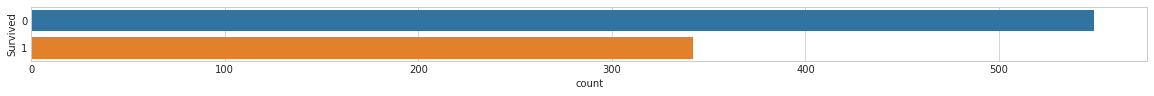

In [21]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [22]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [23]:
df_bin.head()

Survived
0         0
1         1
2         1
3         1
4         0

In [24]:
df_con.head()

Survived
0         0
1         1
2         1
3         1
4         0

### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

#### Let's plot the distribution
We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

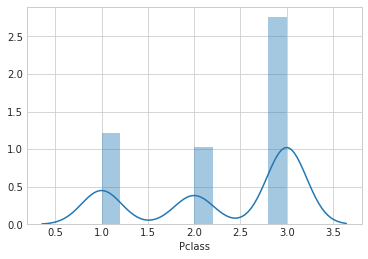

In [25]:
sns.distplot(train.Pclass)

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

How do we know this? Because a passenger in Class 3 doesn't necessarily equal a passenger in Class 2 + a passenger in Class 1.

In [26]:
# How many missing variables does Pclass have?
missing_values['Pclass']

0

Since there are no missing values in Pclass, let's add it to our sub dataframes.

In [27]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name
    
Description: The name of the passenger.

In [30]:
# How many different names are there?
train.Name.value_counts()

Dick, Mr. Albert Adrian                                1
Morley, Mr. William                                    1
Pekoniemi, Mr. Edvard                                  1
Hickman, Mr. Stanley George                            1
Willey, Mr. Edward                                     1
Marechal, Mr. Pierre                                   1
Mionoff, Mr. Stoytcho                                  1
Hassan, Mr. Houssein G N                               1
Abbott, Mr. Rossmore Edward                            1
Vande Walle, Mr. Nestor Cyriel                         1
Eustis, Miss. Elizabeth Mussey                         1
Richards, Mrs. Sidney (Emily Hocking)                  1
Hippach, Miss. Jean Gertrude                           1
Endres, Miss. Caroline Louise                          1
Vander Planke, Mr. Leo Edmondus                        1
Ahlin, Mrs. Johan (Johanna Persdotter Larsson)         1
Brewe, Dr. Arthur Jackson                              1
Chronopoulos, Mr. Apostolos    

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

Can you think of ways you could reduce the number of different names? Or create new features out of the names?

**Note:** Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

### Feature: Sex

Description: The sex of the passenger (male or female).

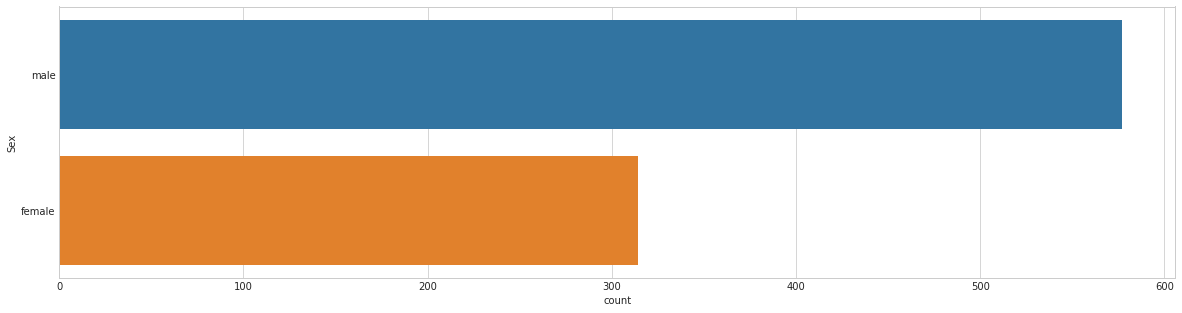

In [32]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [33]:
# Are there any missing values in the Sex column?
missing_values['Sex']

0

Since this is already binary variable (male or female), let's add it straight to our subset dataframes.

In [34]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [35]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

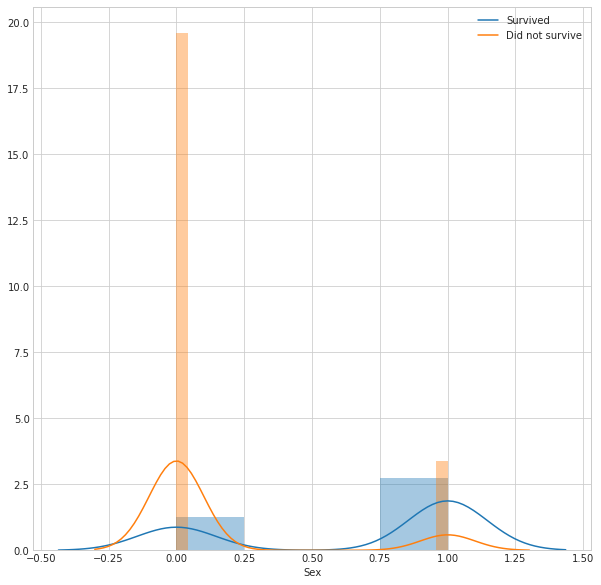

In [36]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

Not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [38]:
# How many missing values does age have?
missing_values['Age']

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.


In [22]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

**Challenge:** How would you fill the missing variables in the `Age` column?

#### Function to create count and distribution visualisations

In [43]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [39]:
# How many missing values does SibSp have?
missing_values['SibSp']

0

In [40]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Let's add SibSp to our subset dataframes and view the distributions.

In [41]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

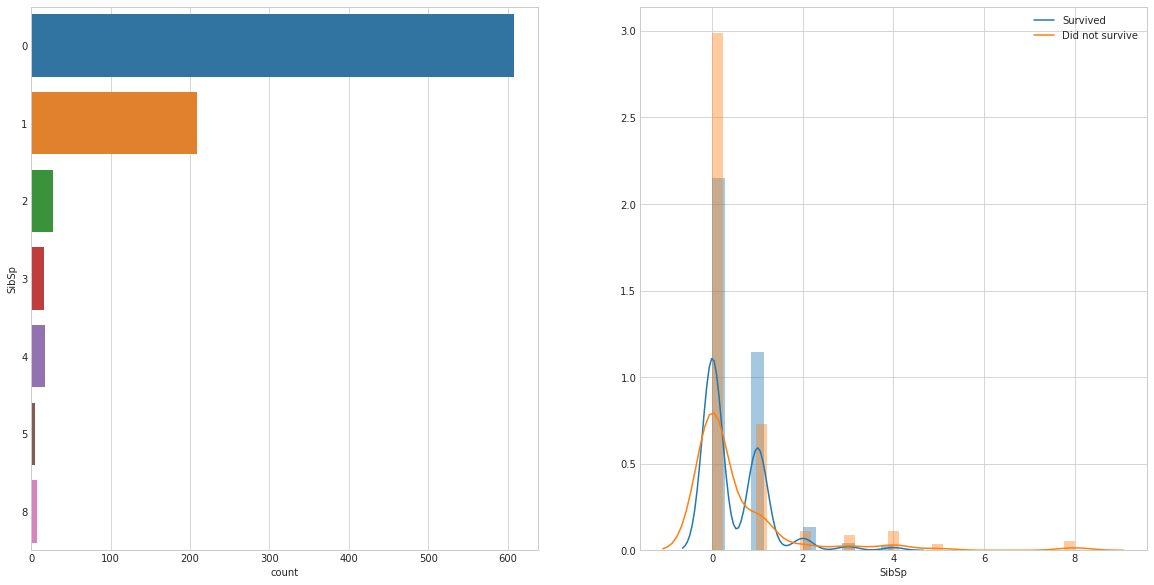

In [44]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

What does the graph on the right tell us?

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [45]:
# How many missing values does SibSp have?
missing_values['Parch']

0

In [46]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [47]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

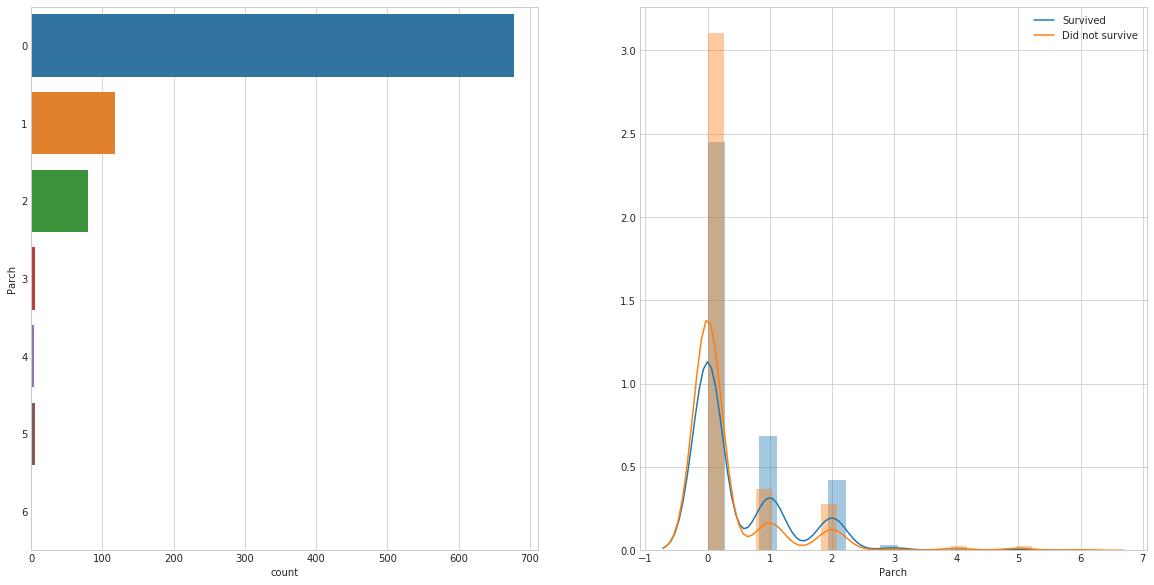

In [48]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

What does the graph on the right tell us about `Parch`?

In [50]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [49]:
df_con.head()

Survived  Pclass     Sex  SibSp  Parch
0         0       3    male      1      0
1         1       1  female      1      0
2         1       3  female      0      0
3         1       1  female      1      0
4         0       3    male      0      0

### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [51]:
# How many missing values does Ticket have?
missing_values['Ticket']

0

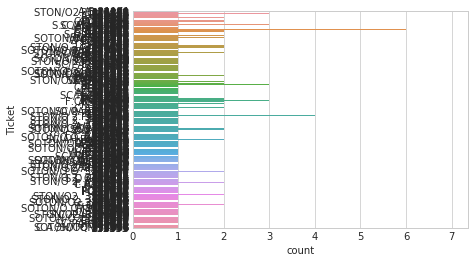

In [52]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

That doesn't look too good, what about another way of looking at it?

In [53]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

1601             7
347082           7
CA. 2343         7
3101295          6
347088           6
CA 2144          6
S.O.C. 14879     5
382652           5
19950            4
W./C. 6608       4
2666             4
349909           4
347077           4
PC 17757         4
113760           4
LINE             4
113781           4
4133             4
17421            4
371110           3
13502            3
24160            3
PC 17760         3
110413           3
363291           3
345773           3
C.A. 31921       3
SC/Paris 2123    3
35273            3
PC 17582         3
                ..
237565           1
113796           1
C 4001           1
2697             1
347063           1
113050           1
112052           1
A/5 3536         1
330932           1
315086           1
350046           1
A/5 21174        1
370372           1
349217           1
371362           1
PC 17595         1
31028            1
113051           1
234604           1
C 7077           1
29104            1
A/5. 10482  

In [54]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


681 unique values is too many for now. So we won't use `Ticket` in our subset dataframes.

There may be some way to reduce this down. 

**Challenge:** How could you reduce the Ticket feature? Is it even possible?

*Hint:* It may be similar to what you could do with Name.

### Feature: Fare

Description: How much the ticket cost.

In [55]:
# How many missing values does Fare have?
missing_values['Fare']

0

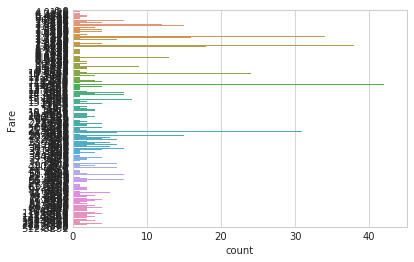

In [57]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [58]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [59]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [60]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [63]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

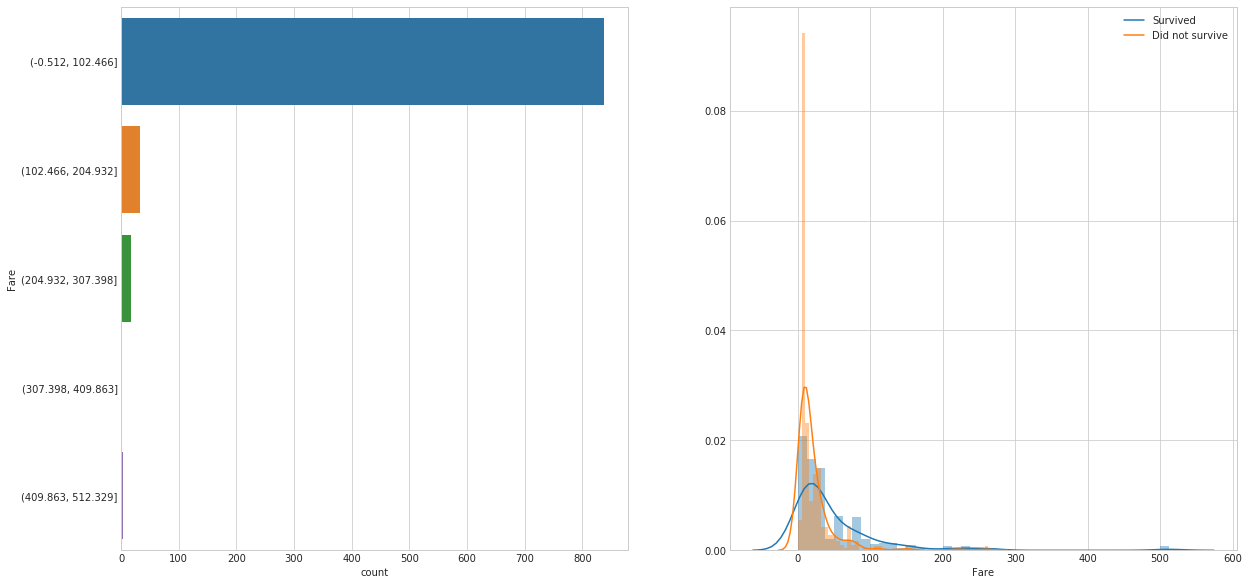

In [64]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

**Challenge:** How would you change the Fare bins?

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [65]:
# How many missing values does Cabin have?
missing_values['Cabin']

687

In [67]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [66]:
# What do the Cabin values look like?
train.Cabin.value_counts()

G6                 4
B96 B98            4
C23 C25 C27        4
C22 C26            3
F2                 3
D                  3
F33                3
E101               3
C93                2
B58 B60            2
D35                2
B18                2
B77                2
C124               2
E44                2
E8                 2
E24                2
D33                2
D20                2
E25                2
C2                 2
E121               2
C92                2
E33                2
F4                 2
D26                2
C123               2
B28                2
B57 B59 B63 B66    2
C68                2
                  ..
D15                1
B39                1
B73                1
D10 D12            1
E12                1
D49                1
B42                1
E34                1
A24                1
A31                1
C32                1
C49                1
D48                1
A32                1
A23                1
C90                1
T            

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

But how could you modify cabin to be more usable?

What could you do about the missing values?

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [68]:
# How many missing values does Embarked have?
missing_values['Embarked']

2

In [70]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

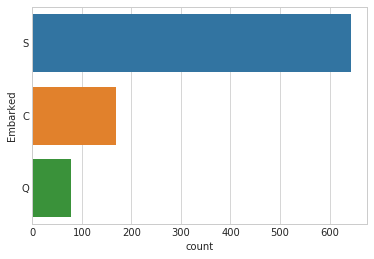

In [46]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

#### How can we deal with the 2 missing values of Embarked?

One option is to drop the two rows which don't have an Embarked value.

Another option would be to randomly assign a value of C, Q or S to each row.

What are the pros and cons of each?

For now, we will remove those rows.

In [71]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [72]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [76]:
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    0      1      0  (-0.512, 102.466]        S
1         1       1    1      1      0  (-0.512, 102.466]        C
2         1       3    1      0      0  (-0.512, 102.466]        S
3         1       1    1      1      0  (-0.512, 102.466]        S
4         0       3    0      0      0  (-0.512, 102.466]        S

In [49]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

Survived  Pclass_1  Pclass_2  Pclass_3  Sex_0  Sex_1  SibSp_0  SibSp_1  \
0         0         0         0         1      1      0        0        1   
1         1         1         0         0      0      1        0        1   
2         1         0         0         1      0      1        1        0   
3         1         1         0         0      0      1        0        1   
4         0         0         0         1      1      0        1        0   

   SibSp_2  SibSp_3     ...      Parch_5  Parch_6  Fare_(-0.512, 102.466]  \
0        0        0     ...            0        0                       1   
1        0        0     ...            0        0                       1   
2        0        0     ...            0        0                       1   
3        0        0     ...            0        0                       1   
4        0        0     ...            0        0                       1   

   Fare_(102.466, 204.932]  Fare_(204.932, 307.398]  Fare_(307.398, 409.863]  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

   Fare_(409.863, 512.329]  Embarked_C  Embarked_Q  Embarked_S  
0                        0           0           0           1  
1                        0           1           0           0  
2                        0           0           0           1  
3                        0           0           0           1  
4                        0           0           0           1  

[5 rows x 28 columns]

In [80]:
df_con.head(10)

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked
0         0       3    male      1      0   7.2500        S
1         1       1  female      1      0  71.2833        C
2         1       3  female      0      0   7.9250        S
3         1       1  female      1      0  53.1000        S
4         0       3    male      0      0   8.0500        S
5         0       3    male      0      0   8.4583        Q
6         0       1    male      0      0  51.8625        S
7         0       3    male      3      1  21.0750        S
8         1       3  female      0      2  11.1333        S
9         1       2  female      1      0  30.0708        C

In [79]:
# Label Encode all continuous values using LabelEncoder()
df_con_enc = df_con.apply(LabelEncoder().fit_transform)

df_con_enc.head(20)

Survived  Pclass  Sex  SibSp  Parch  Fare  Embarked
0          0       2    1      1      0    18         2
1          1       0    0      1      0   207         0
2          1       2    0      0      0    41         2
3          1       0    0      1      0   189         2
4          0       2    1      0      0    43         2
5          0       2    1      0      0    51         1
6          0       0    1      0      0   186         2
7          0       2    1      3      1   124         2
8          1       2    0      0      2    74         2
9          1       1    0      1      0   154         0
10         1       2    0      1      1   110         2
11         1       0    0      0      0   143         2
12         0       2    1      0      0    43         2
13         0       2    1      1      5   158         2
14         0       2    0      0      0    36         2
15         1       1    0      0      0   108         2
16         0       2    1      4      1   151         1
17         1       1    1      0      0    85         2
18         0       2    0      1      0   113         2
19         1       2    0      0      0    16         0

## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [81]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [82]:
selected_df.head()

Survived  Pclass  Sex  SibSp  Parch  Fare  Embarked
0         0       2    1      1      0    18         2
1         1       0    0      1      0   207         0
2         1       2    0      0      0    41         2
3         1       0    0      1      0   189         2
4         0       2    1      0      0    43         2

In [83]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [128]:
# Shape of the data (without labels)
X_train.shape

(889, 6)

In [127]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [87]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [88]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.08
Accuracy CV 10-Fold: 78.52
Running Time: 0:00:04.581568


### K-Nearest Neighbours

In [89]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 81.44
Accuracy CV 10-Fold: 73.68
Running Time: 0:00:00.192228


### Gaussian Naive Bayes

In [90]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 76.72
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.155327


### Linear Support Vector Machines (SVC)

In [91]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 63.55
Accuracy CV 10-Fold: 72.33
Running Time: 0:00:00.422854


### Stochastic Gradient Descent

In [92]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 57.71
Accuracy CV 10-Fold: 61.19
Running Time: 0:00:00.207280


### Decision Tree Classifier

In [94]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:00.145460


### Gradient Boost Trees

In [95]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.39
Accuracy CV 10-Fold: 81.1
Running Time: 0:00:01.340392


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [96]:
# View the data for the CatBoost model
X_train.head()

Pclass  Sex  SibSp  Parch  Fare  Embarked
0       2    1      1      0    18         2
1       0    0      1      0   207         0
2       2    0      0      0    41         2
3       0    0      1      0   189         2
4       2    1      0      0    43         2

In [97]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [100]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 3, 4, 5])

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [101]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [102]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [103]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6838699	total: 125ms	remaining: 2m 4s
1:	learn: 0.6753070	total: 192ms	remaining: 1m 35s
2:	learn: 0.6664907	total: 281ms	remaining: 1m 33s
3:	learn: 0.6580711	total: 338ms	remaining: 1m 24s
4:	learn: 0.6509880	total: 391ms	remaining: 1m 17s
5:	learn: 0.6430105	total: 445ms	remaining: 1m 13s
6:	learn: 0.6363867	total: 497ms	remaining: 1m 10s
7:	learn: 0.6298197	total: 786ms	remaining: 1m 37s
8:	learn: 0.6229042	total: 945ms	remaining: 1m 44s
9:	learn: 0.6164721	total: 1.07s	remaining: 1m 45s
10:	learn: 0.6090541	total: 1.12s	remaining: 1m 40s
11:	learn: 0.6031504	total: 1.33s	remaining: 1m 49s
12:	learn: 0.5977758	total: 1.45s	remaining: 1m 50s
13:	learn: 0.5920107	total: 1.51s	remaining: 1m 46s
14:	learn: 0.5865860	total: 1.64s	remaining: 1m 47s
15:	learn: 0.5815069	total: 1.75s	remaining: 1m 47s
16:	learn: 0.5766008	total: 1.81s	remaining: 1m 44s
17:	learn: 0.5734912	total: 1.89s	remaining: 1m 42s
18:	learn: 0.5683202	total: 2.15s	remaining: 1m 51s
19:	learn: 0.5638584	to

164:	learn: 0.4212457	total: 12.9s	remaining: 1m 5s
165:	learn: 0.4211909	total: 12.9s	remaining: 1m 4s
166:	learn: 0.4211312	total: 13s	remaining: 1m 4s
167:	learn: 0.4210753	total: 13s	remaining: 1m 4s
168:	learn: 0.4209684	total: 13s	remaining: 1m 4s
169:	learn: 0.4208641	total: 13.1s	remaining: 1m 4s
170:	learn: 0.4205448	total: 13.2s	remaining: 1m 3s
171:	learn: 0.4204534	total: 13.3s	remaining: 1m 3s
172:	learn: 0.4203235	total: 13.3s	remaining: 1m 3s
173:	learn: 0.4202465	total: 13.3s	remaining: 1m 3s
174:	learn: 0.4198671	total: 13.4s	remaining: 1m 3s
175:	learn: 0.4197881	total: 13.4s	remaining: 1m 2s
176:	learn: 0.4197223	total: 13.4s	remaining: 1m 2s
177:	learn: 0.4196545	total: 13.5s	remaining: 1m 2s
178:	learn: 0.4195773	total: 13.5s	remaining: 1m 2s
179:	learn: 0.4192400	total: 13.6s	remaining: 1m 1s
180:	learn: 0.4190503	total: 13.7s	remaining: 1m 1s
181:	learn: 0.4187767	total: 13.7s	remaining: 1m 1s
182:	learn: 0.4185464	total: 13.7s	remaining: 1m 1s
183:	learn: 0.4182

330:	learn: 0.4007748	total: 23.6s	remaining: 47.6s
331:	learn: 0.4006011	total: 23.6s	remaining: 47.5s
332:	learn: 0.4005364	total: 23.6s	remaining: 47.3s
333:	learn: 0.4003926	total: 23.6s	remaining: 47.2s
334:	learn: 0.4003832	total: 23.7s	remaining: 47.1s
335:	learn: 0.4003584	total: 23.8s	remaining: 47s
336:	learn: 0.4002643	total: 24s	remaining: 47.2s
337:	learn: 0.4002634	total: 24s	remaining: 47s
338:	learn: 0.4002484	total: 24s	remaining: 46.9s
339:	learn: 0.4002476	total: 24.1s	remaining: 46.7s
340:	learn: 0.4002395	total: 24.1s	remaining: 46.5s
341:	learn: 0.4001220	total: 24.1s	remaining: 46.4s
342:	learn: 0.3998889	total: 24.1s	remaining: 46.2s
343:	learn: 0.3998591	total: 24.2s	remaining: 46.1s
344:	learn: 0.3997578	total: 24.2s	remaining: 46s
345:	learn: 0.3997110	total: 24.3s	remaining: 45.9s
346:	learn: 0.3995905	total: 24.3s	remaining: 45.8s
347:	learn: 0.3995232	total: 24.4s	remaining: 45.7s
348:	learn: 0.3994344	total: 24.4s	remaining: 45.5s
349:	learn: 0.3994203	to

491:	learn: 0.3872298	total: 34.5s	remaining: 35.6s
492:	learn: 0.3871711	total: 34.6s	remaining: 35.6s
493:	learn: 0.3868889	total: 34.8s	remaining: 35.7s
494:	learn: 0.3868303	total: 34.9s	remaining: 35.6s
495:	learn: 0.3867150	total: 35s	remaining: 35.6s
496:	learn: 0.3866346	total: 35.1s	remaining: 35.5s
497:	learn: 0.3865820	total: 35.2s	remaining: 35.4s
498:	learn: 0.3864073	total: 35.3s	remaining: 35.4s
499:	learn: 0.3863897	total: 35.4s	remaining: 35.4s
500:	learn: 0.3863703	total: 35.5s	remaining: 35.4s
501:	learn: 0.3860569	total: 35.6s	remaining: 35.3s
502:	learn: 0.3859608	total: 35.8s	remaining: 35.4s
503:	learn: 0.3859430	total: 35.8s	remaining: 35.3s
504:	learn: 0.3857445	total: 35.9s	remaining: 35.2s
505:	learn: 0.3856026	total: 35.9s	remaining: 35s
506:	learn: 0.3855871	total: 35.9s	remaining: 34.9s
507:	learn: 0.3852677	total: 36.1s	remaining: 34.9s
508:	learn: 0.3850973	total: 36.2s	remaining: 34.9s
509:	learn: 0.3849203	total: 36.3s	remaining: 34.9s
510:	learn: 0.38

651:	learn: 0.3659248	total: 52.6s	remaining: 28.1s
652:	learn: 0.3657830	total: 52.8s	remaining: 28s
653:	learn: 0.3655633	total: 52.9s	remaining: 28s
654:	learn: 0.3653575	total: 53s	remaining: 27.9s
655:	learn: 0.3652963	total: 53.1s	remaining: 27.9s
656:	learn: 0.3652748	total: 53.2s	remaining: 27.8s
657:	learn: 0.3650680	total: 53.3s	remaining: 27.7s
658:	learn: 0.3649764	total: 53.4s	remaining: 27.6s
659:	learn: 0.3648337	total: 53.4s	remaining: 27.5s
660:	learn: 0.3647603	total: 53.4s	remaining: 27.4s
661:	learn: 0.3647349	total: 53.5s	remaining: 27.3s
662:	learn: 0.3644743	total: 53.5s	remaining: 27.2s
663:	learn: 0.3642563	total: 53.7s	remaining: 27.2s
664:	learn: 0.3642117	total: 53.7s	remaining: 27.1s
665:	learn: 0.3641918	total: 53.8s	remaining: 27s
666:	learn: 0.3641678	total: 53.9s	remaining: 26.9s
667:	learn: 0.3637879	total: 54.1s	remaining: 26.9s
668:	learn: 0.3635429	total: 54.2s	remaining: 26.8s
669:	learn: 0.3632952	total: 54.3s	remaining: 26.7s
670:	learn: 0.363238

811:	learn: 0.3479119	total: 1m 3s	remaining: 14.7s
812:	learn: 0.3478894	total: 1m 3s	remaining: 14.7s
813:	learn: 0.3478158	total: 1m 3s	remaining: 14.6s
814:	learn: 0.3477117	total: 1m 3s	remaining: 14.5s
815:	learn: 0.3476177	total: 1m 4s	remaining: 14.4s
816:	learn: 0.3474544	total: 1m 4s	remaining: 14.4s
817:	learn: 0.3473061	total: 1m 4s	remaining: 14.3s
818:	learn: 0.3472280	total: 1m 4s	remaining: 14.2s
819:	learn: 0.3471778	total: 1m 4s	remaining: 14.1s
820:	learn: 0.3471658	total: 1m 4s	remaining: 14s
821:	learn: 0.3468659	total: 1m 4s	remaining: 13.9s
822:	learn: 0.3468045	total: 1m 4s	remaining: 13.9s
823:	learn: 0.3465285	total: 1m 4s	remaining: 13.8s
824:	learn: 0.3464328	total: 1m 4s	remaining: 13.7s
825:	learn: 0.3463774	total: 1m 4s	remaining: 13.6s
826:	learn: 0.3461356	total: 1m 4s	remaining: 13.6s
827:	learn: 0.3458489	total: 1m 4s	remaining: 13.5s
828:	learn: 0.3458394	total: 1m 5s	remaining: 13.4s
829:	learn: 0.3457873	total: 1m 5s	remaining: 13.4s
830:	learn: 0.

968:	learn: 0.3323736	total: 1m 14s	remaining: 2.4s
969:	learn: 0.3321868	total: 1m 14s	remaining: 2.32s
970:	learn: 0.3321546	total: 1m 14s	remaining: 2.24s
971:	learn: 0.3320280	total: 1m 14s	remaining: 2.16s
972:	learn: 0.3319369	total: 1m 15s	remaining: 2.08s
973:	learn: 0.3317490	total: 1m 15s	remaining: 2s
974:	learn: 0.3316592	total: 1m 15s	remaining: 1.93s
975:	learn: 0.3315836	total: 1m 15s	remaining: 1.85s
976:	learn: 0.3314956	total: 1m 15s	remaining: 1.77s
977:	learn: 0.3313894	total: 1m 15s	remaining: 1.69s
978:	learn: 0.3312001	total: 1m 15s	remaining: 1.61s
979:	learn: 0.3311762	total: 1m 15s	remaining: 1.54s
980:	learn: 0.3311653	total: 1m 15s	remaining: 1.46s
981:	learn: 0.3311519	total: 1m 15s	remaining: 1.38s
982:	learn: 0.3309817	total: 1m 15s	remaining: 1.3s
983:	learn: 0.3308975	total: 1m 15s	remaining: 1.23s
984:	learn: 0.3308668	total: 1m 15s	remaining: 1.15s
985:	learn: 0.3308152	total: 1m 15s	remaining: 1.07s
986:	learn: 0.3307605	total: 1m 15s	remaining: 996m

In [104]:
# Perform CatBoost cross-validation
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841514	test: 0.6841147	best: 0.6841147 (0)	total: 2.03s	remaining: 33m 48s
1:	learn: 0.6756348	test: 0.6759832	best: 0.6759832 (1)	total: 4.56s	remaining: 37m 53s
2:	learn: 0.6674292	test: 0.6678939	best: 0.6678939 (2)	total: 5.82s	remaining: 32m 13s
3:	learn: 0.6594136	test: 0.6599622	best: 0.6599622 (3)	total: 6.68s	remaining: 27m 43s
4:	learn: 0.6517690	test: 0.6522749	best: 0.6522749 (4)	total: 7.18s	remaining: 23m 49s
5:	learn: 0.6444828	test: 0.6452430	best: 0.6452430 (5)	total: 7.85s	remaining: 21m 41s
6:	learn: 0.6378062	test: 0.6385765	best: 0.6385765 (6)	total: 8.54s	remaining: 20m 11s
7:	learn: 0.6314324	test: 0.6319496	best: 0.6319496 (7)	total: 9.21s	remaining: 19m 1s
8:	learn: 0.6248844	test: 0.6254854	best: 0.6254854 (8)	total: 10s	remaining: 18m 21s
9:	learn: 0.6187175	test: 0.6194894	best: 0.6194894 (9)	total: 11s	remaining: 18m 13s
10:	learn: 0.6127102	test: 0.6134369	best: 0.6134369 (10)	total: 12s	remaining: 17m 59s
11:	learn: 0.6070970	test: 0.6080206	

92:	learn: 0.4440763	test: 0.4594506	best: 0.4594506 (92)	total: 1m 1s	remaining: 10m 3s
93:	learn: 0.4433029	test: 0.4589431	best: 0.4589431 (93)	total: 1m 2s	remaining: 10m 2s
94:	learn: 0.4427490	test: 0.4585672	best: 0.4585672 (94)	total: 1m 3s	remaining: 10m
95:	learn: 0.4422006	test: 0.4578932	best: 0.4578932 (95)	total: 1m 3s	remaining: 9m 59s
96:	learn: 0.4415155	test: 0.4573488	best: 0.4573488 (96)	total: 1m 4s	remaining: 9m 59s
97:	learn: 0.4409863	test: 0.4568965	best: 0.4568965 (97)	total: 1m 4s	remaining: 9m 57s
98:	learn: 0.4405384	test: 0.4564975	best: 0.4564975 (98)	total: 1m 5s	remaining: 9m 55s
99:	learn: 0.4400034	test: 0.4562579	best: 0.4562579 (99)	total: 1m 5s	remaining: 9m 52s
100:	learn: 0.4394564	test: 0.4559359	best: 0.4559359 (100)	total: 1m 6s	remaining: 9m 50s
101:	learn: 0.4389997	test: 0.4555147	best: 0.4555147 (101)	total: 1m 6s	remaining: 9m 47s
102:	learn: 0.4383723	test: 0.4550696	best: 0.4550696 (102)	total: 1m 7s	remaining: 9m 44s
103:	learn: 0.4378

182:	learn: 0.4137415	test: 0.4391785	best: 0.4391785 (182)	total: 1m 46s	remaining: 7m 56s
183:	learn: 0.4135248	test: 0.4390502	best: 0.4390502 (183)	total: 1m 47s	remaining: 7m 55s
184:	learn: 0.4133417	test: 0.4389017	best: 0.4389017 (184)	total: 1m 47s	remaining: 7m 54s
185:	learn: 0.4131102	test: 0.4386581	best: 0.4386581 (185)	total: 1m 49s	remaining: 7m 57s
186:	learn: 0.4128933	test: 0.4385580	best: 0.4385580 (186)	total: 1m 50s	remaining: 7m 58s
187:	learn: 0.4127963	test: 0.4385223	best: 0.4385223 (187)	total: 1m 51s	remaining: 8m
188:	learn: 0.4126468	test: 0.4383563	best: 0.4383563 (188)	total: 1m 51s	remaining: 8m
189:	learn: 0.4123638	test: 0.4381369	best: 0.4381369 (189)	total: 1m 53s	remaining: 8m 2s
190:	learn: 0.4121288	test: 0.4380998	best: 0.4380998 (190)	total: 1m 53s	remaining: 8m 1s
191:	learn: 0.4120277	test: 0.4380492	best: 0.4380492 (191)	total: 1m 54s	remaining: 8m
192:	learn: 0.4118724	test: 0.4379722	best: 0.4379722 (192)	total: 1m 54s	remaining: 7m 59s
19

272:	learn: 0.4012579	test: 0.4336904	best: 0.4336904 (272)	total: 2m 42s	remaining: 7m 11s
273:	learn: 0.4011055	test: 0.4336360	best: 0.4336360 (273)	total: 2m 43s	remaining: 7m 11s
274:	learn: 0.4009947	test: 0.4336623	best: 0.4336360 (273)	total: 2m 43s	remaining: 7m 10s
275:	learn: 0.4008722	test: 0.4336340	best: 0.4336340 (275)	total: 2m 43s	remaining: 7m 9s
276:	learn: 0.4008139	test: 0.4336346	best: 0.4336340 (275)	total: 2m 44s	remaining: 7m 8s
277:	learn: 0.4007269	test: 0.4335980	best: 0.4335980 (277)	total: 2m 44s	remaining: 7m 7s
278:	learn: 0.4006154	test: 0.4335409	best: 0.4335409 (278)	total: 2m 44s	remaining: 7m 6s
279:	learn: 0.4005218	test: 0.4334784	best: 0.4334784 (279)	total: 2m 45s	remaining: 7m 5s
280:	learn: 0.4004453	test: 0.4334590	best: 0.4334590 (280)	total: 2m 45s	remaining: 7m 4s
281:	learn: 0.4003540	test: 0.4334500	best: 0.4334500 (281)	total: 2m 46s	remaining: 7m 3s
282:	learn: 0.4002591	test: 0.4334921	best: 0.4334500 (281)	total: 2m 46s	remaining: 7m

362:	learn: 0.3935898	test: 0.4313301	best: 0.4313301 (362)	total: 3m 20s	remaining: 5m 51s
363:	learn: 0.3935477	test: 0.4313237	best: 0.4313237 (363)	total: 3m 20s	remaining: 5m 50s
364:	learn: 0.3934382	test: 0.4312820	best: 0.4312820 (364)	total: 3m 20s	remaining: 5m 49s
365:	learn: 0.3933897	test: 0.4312578	best: 0.4312578 (365)	total: 3m 21s	remaining: 5m 48s
366:	learn: 0.3933121	test: 0.4312970	best: 0.4312578 (365)	total: 3m 21s	remaining: 5m 48s
367:	learn: 0.3932484	test: 0.4312883	best: 0.4312578 (365)	total: 3m 22s	remaining: 5m 47s
368:	learn: 0.3931506	test: 0.4312259	best: 0.4312259 (368)	total: 3m 22s	remaining: 5m 46s
369:	learn: 0.3931117	test: 0.4312942	best: 0.4312259 (368)	total: 3m 23s	remaining: 5m 45s
370:	learn: 0.3930263	test: 0.4312834	best: 0.4312259 (368)	total: 3m 23s	remaining: 5m 45s
371:	learn: 0.3929406	test: 0.4312552	best: 0.4312259 (368)	total: 3m 24s	remaining: 5m 45s
372:	learn: 0.3929023	test: 0.4312314	best: 0.4312259 (368)	total: 3m 25s	remain

452:	learn: 0.3866724	test: 0.4301252	best: 0.4299897 (447)	total: 4m 1s	remaining: 4m 51s
453:	learn: 0.3866086	test: 0.4300644	best: 0.4299897 (447)	total: 4m 2s	remaining: 4m 51s
454:	learn: 0.3865285	test: 0.4300805	best: 0.4299897 (447)	total: 4m 2s	remaining: 4m 50s
455:	learn: 0.3864062	test: 0.4300693	best: 0.4299897 (447)	total: 4m 3s	remaining: 4m 50s
456:	learn: 0.3863397	test: 0.4300506	best: 0.4299897 (447)	total: 4m 3s	remaining: 4m 49s
457:	learn: 0.3862679	test: 0.4300017	best: 0.4299897 (447)	total: 4m 3s	remaining: 4m 48s
458:	learn: 0.3861800	test: 0.4299868	best: 0.4299868 (458)	total: 4m 4s	remaining: 4m 48s
459:	learn: 0.3861028	test: 0.4299654	best: 0.4299654 (459)	total: 4m 4s	remaining: 4m 47s
460:	learn: 0.3859993	test: 0.4299483	best: 0.4299483 (460)	total: 4m 5s	remaining: 4m 46s
461:	learn: 0.3858086	test: 0.4299118	best: 0.4299118 (461)	total: 4m 5s	remaining: 4m 46s
462:	learn: 0.3857129	test: 0.4298332	best: 0.4298332 (462)	total: 4m 6s	remaining: 4m 45s

542:	learn: 0.3771765	test: 0.4289615	best: 0.4288653 (540)	total: 4m 54s	remaining: 4m 7s
543:	learn: 0.3770095	test: 0.4288539	best: 0.4288539 (543)	total: 4m 54s	remaining: 4m 6s
544:	learn: 0.3768798	test: 0.4288350	best: 0.4288350 (544)	total: 4m 55s	remaining: 4m 6s
545:	learn: 0.3767695	test: 0.4287726	best: 0.4287726 (545)	total: 4m 55s	remaining: 4m 5s
546:	learn: 0.3765919	test: 0.4287944	best: 0.4287726 (545)	total: 4m 56s	remaining: 4m 5s
547:	learn: 0.3764454	test: 0.4287395	best: 0.4287395 (547)	total: 4m 56s	remaining: 4m 4s
548:	learn: 0.3763043	test: 0.4287076	best: 0.4287076 (548)	total: 4m 57s	remaining: 4m 4s
549:	learn: 0.3761987	test: 0.4286771	best: 0.4286771 (549)	total: 4m 57s	remaining: 4m 3s
550:	learn: 0.3760675	test: 0.4287250	best: 0.4286771 (549)	total: 4m 57s	remaining: 4m 2s
551:	learn: 0.3759826	test: 0.4287235	best: 0.4286771 (549)	total: 4m 58s	remaining: 4m 2s
552:	learn: 0.3758871	test: 0.4287270	best: 0.4286771 (549)	total: 4m 59s	remaining: 4m 1s

632:	learn: 0.3661773	test: 0.4292568	best: 0.4286372 (562)	total: 6m 10s	remaining: 3m 34s
633:	learn: 0.3660191	test: 0.4293237	best: 0.4286372 (562)	total: 6m 11s	remaining: 3m 34s
634:	learn: 0.3658879	test: 0.4292611	best: 0.4286372 (562)	total: 6m 12s	remaining: 3m 34s
635:	learn: 0.3658232	test: 0.4293021	best: 0.4286372 (562)	total: 6m 13s	remaining: 3m 34s
636:	learn: 0.3656971	test: 0.4293292	best: 0.4286372 (562)	total: 6m 14s	remaining: 3m 33s
637:	learn: 0.3655779	test: 0.4293609	best: 0.4286372 (562)	total: 6m 15s	remaining: 3m 33s
638:	learn: 0.3654648	test: 0.4293952	best: 0.4286372 (562)	total: 6m 16s	remaining: 3m 32s
639:	learn: 0.3653706	test: 0.4294439	best: 0.4286372 (562)	total: 6m 18s	remaining: 3m 32s
640:	learn: 0.3652443	test: 0.4293756	best: 0.4286372 (562)	total: 6m 19s	remaining: 3m 32s
641:	learn: 0.3650341	test: 0.4292883	best: 0.4286372 (562)	total: 6m 20s	remaining: 3m 31s
642:	learn: 0.3649286	test: 0.4293512	best: 0.4286372 (562)	total: 6m 20s	remain

722:	learn: 0.3561808	test: 0.4300898	best: 0.4286372 (562)	total: 8m	remaining: 3m 4s
723:	learn: 0.3561082	test: 0.4301347	best: 0.4286372 (562)	total: 8m 1s	remaining: 3m 3s
724:	learn: 0.3560394	test: 0.4301369	best: 0.4286372 (562)	total: 8m 2s	remaining: 3m 3s
725:	learn: 0.3559069	test: 0.4300844	best: 0.4286372 (562)	total: 8m 4s	remaining: 3m 2s
726:	learn: 0.3557789	test: 0.4300931	best: 0.4286372 (562)	total: 8m 5s	remaining: 3m 2s
727:	learn: 0.3556482	test: 0.4301824	best: 0.4286372 (562)	total: 8m 7s	remaining: 3m 2s
728:	learn: 0.3555409	test: 0.4301544	best: 0.4286372 (562)	total: 8m 7s	remaining: 3m 1s
729:	learn: 0.3554042	test: 0.4302252	best: 0.4286372 (562)	total: 8m 8s	remaining: 3m
730:	learn: 0.3553088	test: 0.4302782	best: 0.4286372 (562)	total: 8m 9s	remaining: 3m
731:	learn: 0.3552240	test: 0.4302840	best: 0.4286372 (562)	total: 8m 10s	remaining: 2m 59s
732:	learn: 0.3551386	test: 0.4303254	best: 0.4286372 (562)	total: 8m 11s	remaining: 2m 58s
733:	learn: 0.3

812:	learn: 0.3472103	test: 0.4318658	best: 0.4286372 (562)	total: 9m 19s	remaining: 2m 8s
813:	learn: 0.3471062	test: 0.4317809	best: 0.4286372 (562)	total: 9m 19s	remaining: 2m 7s
814:	learn: 0.3470206	test: 0.4317956	best: 0.4286372 (562)	total: 9m 20s	remaining: 2m 7s
815:	learn: 0.3469316	test: 0.4318134	best: 0.4286372 (562)	total: 9m 21s	remaining: 2m 6s
816:	learn: 0.3468864	test: 0.4318504	best: 0.4286372 (562)	total: 9m 22s	remaining: 2m 5s
817:	learn: 0.3467694	test: 0.4318063	best: 0.4286372 (562)	total: 9m 22s	remaining: 2m 5s
818:	learn: 0.3466756	test: 0.4317816	best: 0.4286372 (562)	total: 9m 24s	remaining: 2m 4s
819:	learn: 0.3465316	test: 0.4317439	best: 0.4286372 (562)	total: 9m 25s	remaining: 2m 4s
820:	learn: 0.3463530	test: 0.4317536	best: 0.4286372 (562)	total: 9m 25s	remaining: 2m 3s
821:	learn: 0.3462674	test: 0.4317405	best: 0.4286372 (562)	total: 9m 26s	remaining: 2m 2s
822:	learn: 0.3462094	test: 0.4317040	best: 0.4286372 (562)	total: 9m 27s	remaining: 2m 2s

902:	learn: 0.3389544	test: 0.4324375	best: 0.4286372 (562)	total: 10m 15s	remaining: 1m 6s
903:	learn: 0.3388294	test: 0.4324033	best: 0.4286372 (562)	total: 10m 16s	remaining: 1m 5s
904:	learn: 0.3387329	test: 0.4323932	best: 0.4286372 (562)	total: 10m 16s	remaining: 1m 4s
905:	learn: 0.3386599	test: 0.4324614	best: 0.4286372 (562)	total: 10m 17s	remaining: 1m 4s
906:	learn: 0.3385835	test: 0.4325322	best: 0.4286372 (562)	total: 10m 18s	remaining: 1m 3s
907:	learn: 0.3385217	test: 0.4325602	best: 0.4286372 (562)	total: 10m 18s	remaining: 1m 2s
908:	learn: 0.3384303	test: 0.4326131	best: 0.4286372 (562)	total: 10m 19s	remaining: 1m 2s
909:	learn: 0.3383057	test: 0.4326634	best: 0.4286372 (562)	total: 10m 20s	remaining: 1m 1s
910:	learn: 0.3382450	test: 0.4326675	best: 0.4286372 (562)	total: 10m 20s	remaining: 1m
911:	learn: 0.3381507	test: 0.4326842	best: 0.4286372 (562)	total: 10m 21s	remaining: 60s
912:	learn: 0.3380346	test: 0.4326116	best: 0.4286372 (562)	total: 10m 21s	remaining:

992:	learn: 0.3311008	test: 0.4330629	best: 0.4286372 (562)	total: 11m 15s	remaining: 4.76s
993:	learn: 0.3310592	test: 0.4330897	best: 0.4286372 (562)	total: 11m 16s	remaining: 4.08s
994:	learn: 0.3309647	test: 0.4330679	best: 0.4286372 (562)	total: 11m 19s	remaining: 3.41s
995:	learn: 0.3308721	test: 0.4331027	best: 0.4286372 (562)	total: 11m 20s	remaining: 2.73s
996:	learn: 0.3307998	test: 0.4332199	best: 0.4286372 (562)	total: 11m 23s	remaining: 2.06s
997:	learn: 0.3306803	test: 0.4332889	best: 0.4286372 (562)	total: 11m 24s	remaining: 1.37s
998:	learn: 0.3306014	test: 0.4333159	best: 0.4286372 (562)	total: 11m 27s	remaining: 688ms
999:	learn: 0.3305232	test: 0.4333327	best: 0.4286372 (562)	total: 11m 30s	remaining: 0us


In [105]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy CV 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 87.63
Accuracy CV 10-Fold: 81.78
Running Time: 0:11:33.146630


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

### Regular accuracy scores

In [106]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


Model  Score
5               Decision Tree  92.46
7                    CatBoost  87.63
6     Gradient Boosting Trees  86.39
0                         KNN  81.44
1         Logistic Regression  79.08
2                 Naive Bayes  76.72
4                  Linear SVC  63.55
3  Stochastic Gradient Decent  57.71

In [107]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


Model  Score
7                    CatBoost  81.78
6     Gradient Boosting Trees  81.10
5               Decision Tree  79.42
1         Logistic Regression  78.52
2                 Naive Bayes  76.38
0                         KNN  73.68
4                  Linear SVC  72.33
3  Stochastic Gradient Decent  61.19

We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

## Feature Importance
Which features of the best model were most important for making predictions?

In [108]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

imp       col
2   9.811795     SibSp
5  11.489122  Embarked
4  12.736799      Fare
3  13.778596     Parch
0  22.965584    Pclass
1  29.218104       Sex

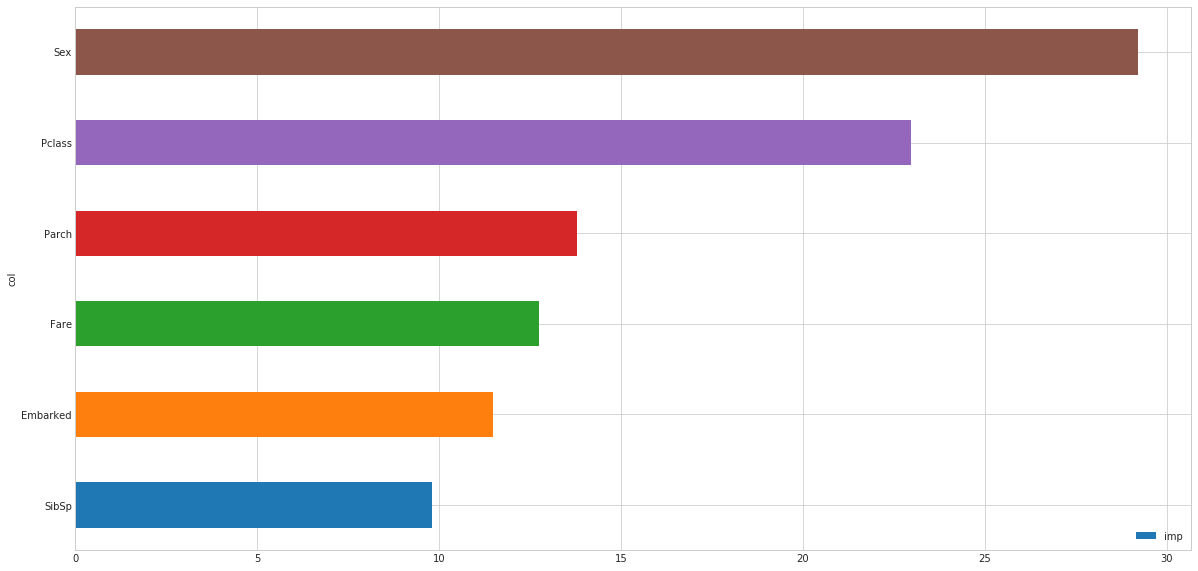

In [109]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score.**

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [110]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8798765427169649
Recall: 0.7200647058823528
F1: 0.7912832504423744
AUC: 0.9059489713918354


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Challenge:** What are some ways to visualise precision and recall? 
*Hint:* You may want to look into what a confusion matrix is, you can find much more information in this blog post: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [114]:
# We need our test dataframe to look like this one
X_train.head()

Pclass  Sex  SibSp  Parch  Fare  Embarked
0       2    1      1      0    18         2
1       0    0      1      0   207         0
2       2    0      0      0    41         2
3       0    0      1      0   189         2
4       2    1      0      0    43         2

In [10]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [115]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [116]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns]
                                     .apply(LabelEncoder().fit_transform))

In [117]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1.])

In [120]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

PassengerId  Survived
0          892       0.0
1          893       0.0
2          894       0.0
3          895       0.0
4          896       0.0

In [119]:
# What does our submission have to look like?
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

We need our `submission` dataframe to look like the `gender_submisison` dataframe, so we'll turn the `Survived` column into integers.

In [121]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [122]:
# How does our submission dataframe look?
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [123]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [124]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [125]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0